In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utility_functions import *
from weight_matrix import *
from parameters import *
from scipy.special import lambertw, exp1, expi, hyp2f1, gamma, gammaincc
from scipy import optimize, integrate
import mpmath as mp
from natsort import natsorted
from glob import glob
from phi import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from hmmlearn import hmm


In [2]:
def sim_network_Homogeneous_Perturb(parameters, W, t_start_perturb1, t_start_perturb2, t_end_perturb1, t_end_perturb2, perturb_amp):

    # Unpackage Parameters
    dt = parameters.dt
    gain = parameters.gain
    N = parameters.N
    Etr = parameters.Etr
    trans = parameters.trans
    power = parameters.power
    thres = parameters.Vthres
    Nt = parameters.Nt
    simPhi = parameters.simPhi
    VReset = parameters.Vreset

    # Simulation variables
    t = 0
    numSpikes = 0
    maxSpikes = parameters.maxSpikes  # 500 Hz / neuron
    spkTimes = np.zeros((int(maxSpikes), 2))  # store spike times and neuron labels
    memVol = np.zeros((Nt, N))
    gSyn = np.zeros((Nt, N))
    spkTrain = np.zeros((Nt, N))

    # Initialization
    V = np.random.uniform(0, 2, size=(N,))
    noise = np.ones((N, )) * parameters.IeE
    spks = np.zeros((N, ))
    tauMem = 1 / parameters.tauE * np.ones(int(parameters.N), )
    memVol[0,:] = V.copy()
    spkTrain[0,:] = spks.copy()
    gSyn[0,:] = noise.copy()

    count = 0

    for i in range(0, Nt - 1, 1):

        t += dt
        
        if (t >= t_start_perturb1) and (t < t_end_perturb1):
            E = noise + perturb_amp
        elif (t >= t_start_perturb2) and (t < t_end_perturb2):
            E = noise - perturb_amp
        else:
            E = noise
        
        V += tauMem * ( dt * (-V + E) + np.dot(W, spks) ) - V * spks

        # Refractory Period
        # for j in range(N):
        #     if (lastAP[j] + Etr / dt) >= (i + 1):
        #         memVol[i + 1, j] = 0

        # Decide if each neuron spikes, update synaptic output of spiking neurons each neuron's rate is phi(g)
        if simPhi ==0:
            r = threshold_power_law(V, gain, power)
        elif simPhi == 1:
            r = exponential(V, gain, thres)
        
        r[r > 1/dt] = 1/dt
            
        try:
            # spkTrain[i + 1, :] = np.random.poisson(r * dt, size=(N,))
            spks = np.random.binomial(n=1, p=dt*r)
        except:
            break

        idx = np.where(spkTrain[i + 1, :] >= 1)

        count += sum(1 * (spks > 1))  # Count to check how many >1 spike incidents occur

        if t > trans:
            for j in range(N):
                if spks[j] >= 1 and numSpikes < maxSpikes:
                    spkTimes[numSpikes, 0] = t  # Save time at which spike occurred
                    spkTimes[numSpikes, 1] = j  # Save the neuron which spiked

                    numSpikes += 1

        memVol[i+1, :] = V.copy()
        spkTrain[i+1,:] = spks.copy()
        gSyn[i+1,:] = E.copy()


    return spkTrain, memVol, gSyn, spkTimes, count

In [3]:
E = np.arange(0, 2, 0.001)
J = np.arange(0, 8, 0.001)
alpha = np.arange(0, 5, 0.001)

In [4]:
# Phase plot for alpha = 1
J_plot_a1 = 2 + 2 * np.sqrt(1-E)

/var/folders/7x/_g6cnzvd605glvq83cdzyh1r0000gn/T/ipykernel_1123/1913245188.py:2: RuntimeWarning: invalid value encountered in sqrt
  J_plot_a1 = 2 + 2 * np.sqrt(1-E)


In [5]:
# Phase plot for alpha = 2
a2 = -27
b2 = 36 * (J + 2) * (J + 1) - 4 * (J + 2)**3 - 54 * J
c2 = 36 * J * (J + 1) * (J + 2) - 4 * J * (J + 2)**3 + 4 * (J + 2)**2 * (J + 1)**2 - 32 * (J + 1)**3 - 27 * J**2

E_plot_A2_Plus = (-b2 + np.sqrt(b2**2 - 4 * a2 * c2)) / (2 * a2)
E_plot_A2_Minus = (-b2 - np.sqrt(b2**2 - 4 * a2 * c2)) / (2 * a2)

/var/folders/7x/_g6cnzvd605glvq83cdzyh1r0000gn/T/ipykernel_1123/4007343805.py:6: RuntimeWarning: invalid value encountered in sqrt
  E_plot_A2_Plus = (-b2 + np.sqrt(b2**2 - 4 * a2 * c2)) / (2 * a2)
/var/folders/7x/_g6cnzvd605glvq83cdzyh1r0000gn/T/ipykernel_1123/4007343805.py:7: RuntimeWarning: invalid value encountered in sqrt
  E_plot_A2_Minus = (-b2 - np.sqrt(b2**2 - 4 * a2 * c2)) / (2 * a2)


In [6]:
# Phase plot for alpha = 3
b = -(J + 3)
c = 3*(J + 1)
d = -3*J

A3 = -256
B3 = (768 * J - 192 * b * d - 128 * c**2 + 144 * b**2 * c - 27 * b**4)
C3 = -(768 * J**2 + 2 * J * (-192 * b * d - 128 * c**2 + 144 * b**2 * c - 27 * b**4) + 144 * c * d**2 - 6 * b**2 * d**2 - 80 * b * c**2 * d + 16 * c**4 + 18 * b**3 * c * d - 4 * b**2 * c**3)
D3 = (256 * J**3 + J**2 * (-192 * b * d - 128 * c**2 + 144 * b**2 * c - 27 * b**4) + J * (144 * c * d**2 - 6 * b**2 * d**2 - 80 * b * c**2 * d + 16 * c**4 + 18 * b**3 * c * d - 4 * b**2 * c**3) + 18 * b * c * d**3 - 27 * d**4 - 4 * c**3 * d**2 - 4 * b**3 * d**3 + b**2 * c**2 * d**2)

p = (3 * A3 * C3 - B3**2) / (3 * A3**2)
q = (2 * B3**3 - 9 * A3 * B3 * C3 + 27 * A3**2 * D3) / (27 * A3**3)

E_plot_A3_1 = 2 * np.sqrt(-p / 3) * np.cos( (1/3) * np.arccos( ((3*q)/(2*p)) * np.sqrt(-3/p)) ) - (B3 / (3 * A3))
E_plot_A3_2 = 2 * np.sqrt(-p / 3) * np.cos( (1/3) * np.arccos( ((3*q)/(2*p)) * np.sqrt(-3/p)) - (2 * np.pi * 1 / 3) ) - (B3 / (3 * A3))
E_plot_A3_3 = 2 * np.sqrt(-p / 3) * np.cos( (1/3) * np.arccos( ((3*q)/(2*p)) * np.sqrt(-3/p)) - (2 * np.pi * 2 / 3) ) - (B3 / (3 * A3))

idx = np.where(np.diff(E_plot_A3_2) > 0)[0][0]
E_plot_A3_2[idx:] = np.nan

idx = np.where(np.diff(E_plot_A3_3) < 0)[0][0]
E_plot_A3_3[:idx] = np.nan


/var/folders/7x/_g6cnzvd605glvq83cdzyh1r0000gn/T/ipykernel_1123/1999379055.py:14: RuntimeWarning: divide by zero encountered in divide
  E_plot_A3_1 = 2 * np.sqrt(-p / 3) * np.cos( (1/3) * np.arccos( ((3*q)/(2*p)) * np.sqrt(-3/p)) ) - (B3 / (3 * A3))
/var/folders/7x/_g6cnzvd605glvq83cdzyh1r0000gn/T/ipykernel_1123/1999379055.py:14: RuntimeWarning: invalid value encountered in sqrt
  E_plot_A3_1 = 2 * np.sqrt(-p / 3) * np.cos( (1/3) * np.arccos( ((3*q)/(2*p)) * np.sqrt(-3/p)) ) - (B3 / (3 * A3))
/var/folders/7x/_g6cnzvd605glvq83cdzyh1r0000gn/T/ipykernel_1123/1999379055.py:14: RuntimeWarning: invalid value encountered in arccos
  E_plot_A3_1 = 2 * np.sqrt(-p / 3) * np.cos( (1/3) * np.arccos( ((3*q)/(2*p)) * np.sqrt(-3/p)) ) - (B3 / (3 * A3))
/var/folders/7x/_g6cnzvd605glvq83cdzyh1r0000gn/T/ipykernel_1123/1999379055.py:15: RuntimeWarning: divide by zero encountered in divide
  E_plot_A3_2 = 2 * np.sqrt(-p / 3) * np.cos( (1/3) * np.arccos( ((3*q)/(2*p)) * np.sqrt(-3/p)) - (2 * np.pi * 1 / 3

In [7]:
parameters = network_params()
parameters.N = 50
parameters.IeE = 1.05
parameters.wEE = 3.2
parameters.tstop = 100
parameters.Nt = int(parameters.tstop / parameters.dt)

t_start_perturb1 = 10
t_start_perturb2 = 50
t_end_perturb1 = 15
t_end_perturb2 = 55
perturb_amp = 2.0

W = get_weight_matrix_Exc_N(parameters)
spkTrain, memVol, gSyn, spkTimes, count = sim_network_Homogeneous_Perturb(parameters, W, t_start_perturb1, t_start_perturb2, t_end_perturb1, t_end_perturb2, perturb_amp)

In [8]:
parameters = network_params()
parameters.N = 50
parameters.IeE = 1.07
parameters.wEE = 3.0
parameters.tstop = 100
parameters.Nt = int(parameters.tstop / parameters.dt)

t_start_perturb1 = 0
t_start_perturb2 = 0
t_end_perturb1 = 0
t_end_perturb2 = 0
perturb_amp = 2.0

np.random.seed(42658793)
W = get_weight_matrix_Exc_N(parameters)
spkTrainS, memVolS, gSynS, spkTimesS, countS = sim_network_Homogeneous_Perturb(parameters, W, t_start_perturb1, t_start_perturb2, t_end_perturb1, t_end_perturb2, perturb_amp)

t_plot = np.arange(0, parameters.Nt, 1) * parameters.dt

In [9]:
filename = '/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 2/500Data_TPL2.npz'
data = np.load(filename)

fr_Sim_L = data['arr_0']
fr_Sim_H = data['arr_1']

fr_MF_L = data['arr_4']
fr_MF_H = data['arr_5']

fr_MF_Perturb_L = data['arr_8']
fr_MF_Perturb_H = data['arr_9']

fr_MF_SC_L = data['arr_12']
fr_MF_SC_H = data['arr_13']

In [10]:
filename = '/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 2/Data_Renewal_TPL2_Homogeneous.npz'
data = np.load(filename)

n_Renewal_L = data['arr_0']
n_Renewal_H = data['arr_1']

n_Renewal_L = np.nan_to_num(n_Renewal_L)
n_Renewal_H = np.nan_to_num(n_Renewal_H)

In [11]:
alpha_plot = np.arange(1, 1000, 0.1)
J_cusp = 1 + ((alpha_plot - 1)/(alpha_plot + 1))**((1-alpha_plot)/alpha_plot)
E_cusp = 1 + ((alpha_plot - 1)/(alpha_plot + 1))**((1+alpha_plot)/alpha_plot)

idx1 = np.where(np.abs(alpha_plot - 1.) < 10e-8)[0][0]
idx2 = np.where(np.abs(alpha_plot - 2.) < 10e-8)[0][0]
idx3 = np.where(np.abs(alpha_plot - 3.) < 10e-8)[0][0]

In [12]:
E_plot = np.arange(0, 1.1, 0.1)
E_plot = np.concatenate((E_plot, np.arange(1.01, 1.09, 0.01)))
E_plot = np.concatenate((E_plot, np.arange(1.1, 2.1, 0.1)))

In [1]:
fontsize=10
J_limL = 2.0
J_limH = 5.0
E_limL = 0.5
E_limH = 1.5

f, ax = plt.subplots(2,4,figsize=(8.5,4.8),dpi=600,layout='constrained')

ax[0, 0].axis('off')

ax[0, 1].plot(J_plot_a1, E, 'k', linewidth=2)
ax[0, 1].hlines(1.0, J_limL, J_limH, 'k', linewidth=2)
ax[0, 1].plot(J_cusp[idx1], E_cusp[idx1], 'o', color='violet')
ax[0, 1].set_xlabel('J', fontsize=fontsize)
ax[0, 1].set_ylabel('$\\mathcal{E}$', fontsize=fontsize)
ax[0, 1].text(2.25, 0.75, 'Q', fontsize=fontsize)
ax[0, 1].text(3.5, 0.75, 'B(H,Q)', fontsize=fontsize)
ax[0, 1].text(3.5, 1.25, 'H', fontsize=fontsize)
xticks = [2.0, 3.5, 5.0]
yticks = [0.5, 1.0, 1.5]
ax[0, 1].set_xticks(xticks, xticks, fontsize=fontsize)
ax[0, 1].set_yticks(yticks, yticks, fontsize=fontsize)
ax[0, 1].set_xlim(J_limL, J_limH)
ax[0, 1].set_ylim(E_limL, E_limH)
ax[0, 1].set_aspect(1./ax[0,1].get_data_ratio())

ax[0, 2].plot(J, E_plot_A2_Plus, 'k', linewidth=2)
ax[0, 2].plot(J, E_plot_A2_Minus, 'k', linewidth=2)
ax[0, 2].plot(3.2, 1.05, 'X', color='orange', markersize=4.0)
ax[0, 2].plot(3.0, 1.07, 's', color='orange', markersize=4.0)
ax[0, 2].hlines(1.0, J_limL, J_limH, 'k', linewidth=2)
ax[0, 2].plot(J_cusp[idx2], E_cusp[idx2], 'o', color='blue')
ax[0, 2].set_xlabel('J', fontsize=fontsize)
ax[0, 2].set_ylabel('$\\mathcal{E}$', fontsize=fontsize)
ax[0, 2].text(2.25, 0.75, 'Q', fontsize=fontsize)
ax[0, 2].text(3.5, 0.75, 'B(H,Q)', fontsize=fontsize)
ax[0, 2].text(3.7, 1.25, 'H', fontsize=fontsize)
ax[0, 2].text(2.1, 1.3, 'B(H,L)', fontsize=fontsize)
ax[0, 2].plot([2.7, 3.6], [1.25, 1.05], '-k', linewidth=0.5)
ax[0, 2].set_xticks(xticks, xticks, fontsize=fontsize)
ax[0, 2].set_yticks(yticks, yticks, fontsize=fontsize)
ax[0, 2].set_xlim(J_limL, J_limH)
ax[0, 2].set_ylim(E_limL, E_limH)
ax[0, 2].set_aspect(1./ax[0,2].get_data_ratio())

ax[0, 3].plot(J, E_plot_A3_1, 'k', linewidth=2)
ax[0, 3].plot(J, E_plot_A3_2, 'k', linewidth=2)
ax[0, 3].plot(J, E_plot_A3_3, 'k', linewidth=2)
ax[0, 3].hlines(1.0, J_limL, J_limH, 'k', linewidth=2)
ax[0, 3].plot(J_cusp[idx3], E_cusp[idx3], 'o', color='yellow')
ax[0, 3].set_xlabel('J', fontsize=fontsize)
ax[0, 3].set_ylabel('$\\mathcal{E}$', fontsize=fontsize)
ax[0, 3].text(2.25, 0.75, 'Q', fontsize=fontsize)
ax[0, 3].text(3.5, 0.75, 'B(H,Q)', fontsize=fontsize)
ax[0, 3].text(3.7, 1.35, 'H', fontsize=fontsize)
ax[0, 3].text(3.4, 1.1, 'B(H,L)', fontsize=fontsize)
ax[0, 3].set_xticks(xticks, xticks, fontsize=fontsize)
ax[0, 3].set_yticks(yticks, yticks, fontsize=fontsize)
ax[0, 3].set_xlim(J_limL, J_limH)
ax[0, 3].set_ylim(E_limL, E_limH)
ax[0, 3].set_aspect(1./ax[0,3].get_data_ratio())

ax[1, 0].plot(spkTimes[:,0], spkTimes[:,1],'|k', markersize=.8)
ax[1, 0].set_xlabel('Time (ms/{})'.format(r'$\tau$'), fontsize=fontsize)
ax[1, 0].set_ylabel('Neuron #', fontsize=fontsize)
ax[1, 0].set_aspect(1./ax[1,0].get_data_ratio())
xticks = [0, 50, 100]
yticks = [0, 25, 50]
ax[1, 0].set_xticks(xticks, xticks, fontsize=fontsize)
ax[1, 0].set_yticks(yticks, yticks, fontsize=fontsize)
inset_ax1 = ax[1, 0].inset_axes([0., 1.05, 1.0, 0.2])
inset_ax1.plot(t_plot, gSyn, 'k', linewidth=1.0)
inset_ax1.set_xticks([])
inset_ax1.set_yticks([]) 
inset_ax1.spines[['left', 'right', 'top', 'bottom']].set_visible(False)


ax[1, 1].plot(spkTimesS[:,0], spkTimesS[:,1],'|k', markersize=.8)
ax[1, 1].set_xlabel('Time (ms/{})'.format(r'$\tau$'), fontsize=fontsize)
ax[1, 1].set_ylabel('Neuron #', fontsize=fontsize)
ax[1, 1].set_aspect(1./ax[1,0].get_data_ratio())
xticks = [0, 50, 100]
yticks = [0, 25, 50]
ax[1, 1].set_xticks(xticks, xticks, fontsize=fontsize)
ax[1, 1].set_yticks(yticks, yticks, fontsize=fontsize)
inset_ax2 = ax[1, 1].inset_axes([0., 1.05, 1.0, 0.2])
inset_ax2.plot(t_plot, gSynS, 'k', linewidth=1.0)
inset_ax2.set_xticks([])
inset_ax2.set_yticks([]) 
inset_ax2.spines[['left', 'right', 'top', 'bottom']].set_visible(False)


idxE = np.where(np.abs((fr_MF_H - fr_MF_L) < 10e-8) & (fr_MF_H > 0.))[0][0]
idxL = np.where(np.abs(E_plot - 1.08) < 10e-4)[0][0] + 1
ax[1, 2].plot(E_plot, fr_MF_H, '-g', linewidth=2.0)
ax[1, 2].plot(E_plot[0:idxE-1], fr_MF_L[0:idxE-1], '-g', linewidth=2.0, label='MF')
ax[1, 2].plot(E_plot, fr_MF_Perturb_H, '-c', linewidth=2.0)
ax[1, 2].plot(E_plot[0:idxE-1], fr_MF_Perturb_L[0:idxE-1], '-c', linewidth=2.0, label='1 loop')
ax[1, 2].plot(E_plot, n_Renewal_H, '-', color='navy', linewidth=2.0, label='Exact')
ax[1, 2].plot(E_plot[0:idxE-1], n_Renewal_L[0:idxE-1], '-', color='navy', linewidth=2.0)
ax[1, 2].plot(E_plot, fr_Sim_H, 'o', color='brown',markerfacecolor='None')
ax[1, 2].plot(E_plot[0:idxE-1], fr_Sim_L[0:idxE-1], 'o', color='brown',markerfacecolor='None', label='Sim')
ax[1, 2].set_xlabel('$\\mathcal{E}$', fontsize=fontsize)
ax[1, 2].set_ylabel('Firing Rate', fontsize=fontsize)
xticks = [0.0, 1.0, 2.0]
yticks = [0.0, 2.0, 4.0]
ax[1, 2].set_xticks(xticks, xticks, fontsize=fontsize)
ax[1, 2].set_yticks(yticks, yticks, fontsize=fontsize)
inset_ax3 = ax[1, 2].inset_axes([0.05, 0.7, 0.5, 0.3])
inset_ax3.plot(E_plot[11:idxL], fr_Sim_L[11:idxL], 'o', color='brown',markerfacecolor='white')
inset_ax3.plot(E_plot[11:idxL], fr_MF_L[11:idxL], '-g', linewidth=2.0, label='MF')
inset_ax3.plot(E_plot[11:idxL], fr_MF_Perturb_L[11:idxL], '-c', linewidth=2.0)
inset_ax3.plot(E_plot[11:idxL], n_Renewal_L[11:idxL], '-', color='navy', linewidth=2.0)
xticks = [1.01, 1.08]
yticks = [0.0, 0.02]
inset_ax3.set_xticks(xticks, xticks, fontsize=8)
inset_ax3.set_yticks(yticks, yticks, fontsize=8) 
inset_ax3.yaxis.tick_right()
ax[1, 2].legend(frameon=False, loc=[0.01, 0.1],fontsize=7)
ax[1, 2].set_aspect(1./ax[1,2].get_data_ratio())


ax[1, 3].plot(J_cusp, E_cusp, '--ok')
ax[1, 3].plot(J_cusp[idx1], E_cusp[idx1], 'o',color='violet', markersize=8, label = '$\\alpha=1$')
ax[1, 3].plot(J_cusp[idx2], E_cusp[idx2], 'o', color='blue', markersize=8, label = '$\\alpha=2$')
ax[1, 3].plot(J_cusp[idx3], E_cusp[idx3], 'o', color='yellow', markersize=8, label = '$\\alpha=3$')
ax[1, 3].plot(J_cusp[-1], E_cusp[-1], 'o', color='red', markersize=8, label = '$\\alpha=\\infty$')
ax[1, 3].set_xlabel('J', fontsize=fontsize)
ax[1, 3].set_ylabel('$\\mathcal{E}$', fontsize=fontsize)
ax[1, 3].legend(frameon=False, fontsize=8, loc=[0.0,0.15])
ax[1, 3].set_aspect(1./ax[1,3].get_data_ratio())
ax[1, 3].set_xlim(1.9,2.8)
ax[1, 3].set_ylim(0.9,2.1)
xticks = [2.0, 2.4, 2.8]
yticks = [1.0, 1.5, 2.0]
ax[1, 3].set_xticks(xticks, xticks, fontsize=fontsize)
ax[1, 3].set_yticks(yticks, yticks, fontsize=fontsize)

sns.despine(ax=ax[0, 1])
sns.despine(ax=ax[0, 2])
sns.despine(ax=ax[0, 3])
sns.despine(ax=ax[1, 0])
sns.despine(ax=ax[1, 1])
sns.despine(ax=ax[1, 2])
sns.despine(ax=ax[1, 3])

f.savefig('./Figures/Figure2.pdf', format='pdf')
plt.show()


NameError: name 'plt' is not defined

(2.7, 3.2)

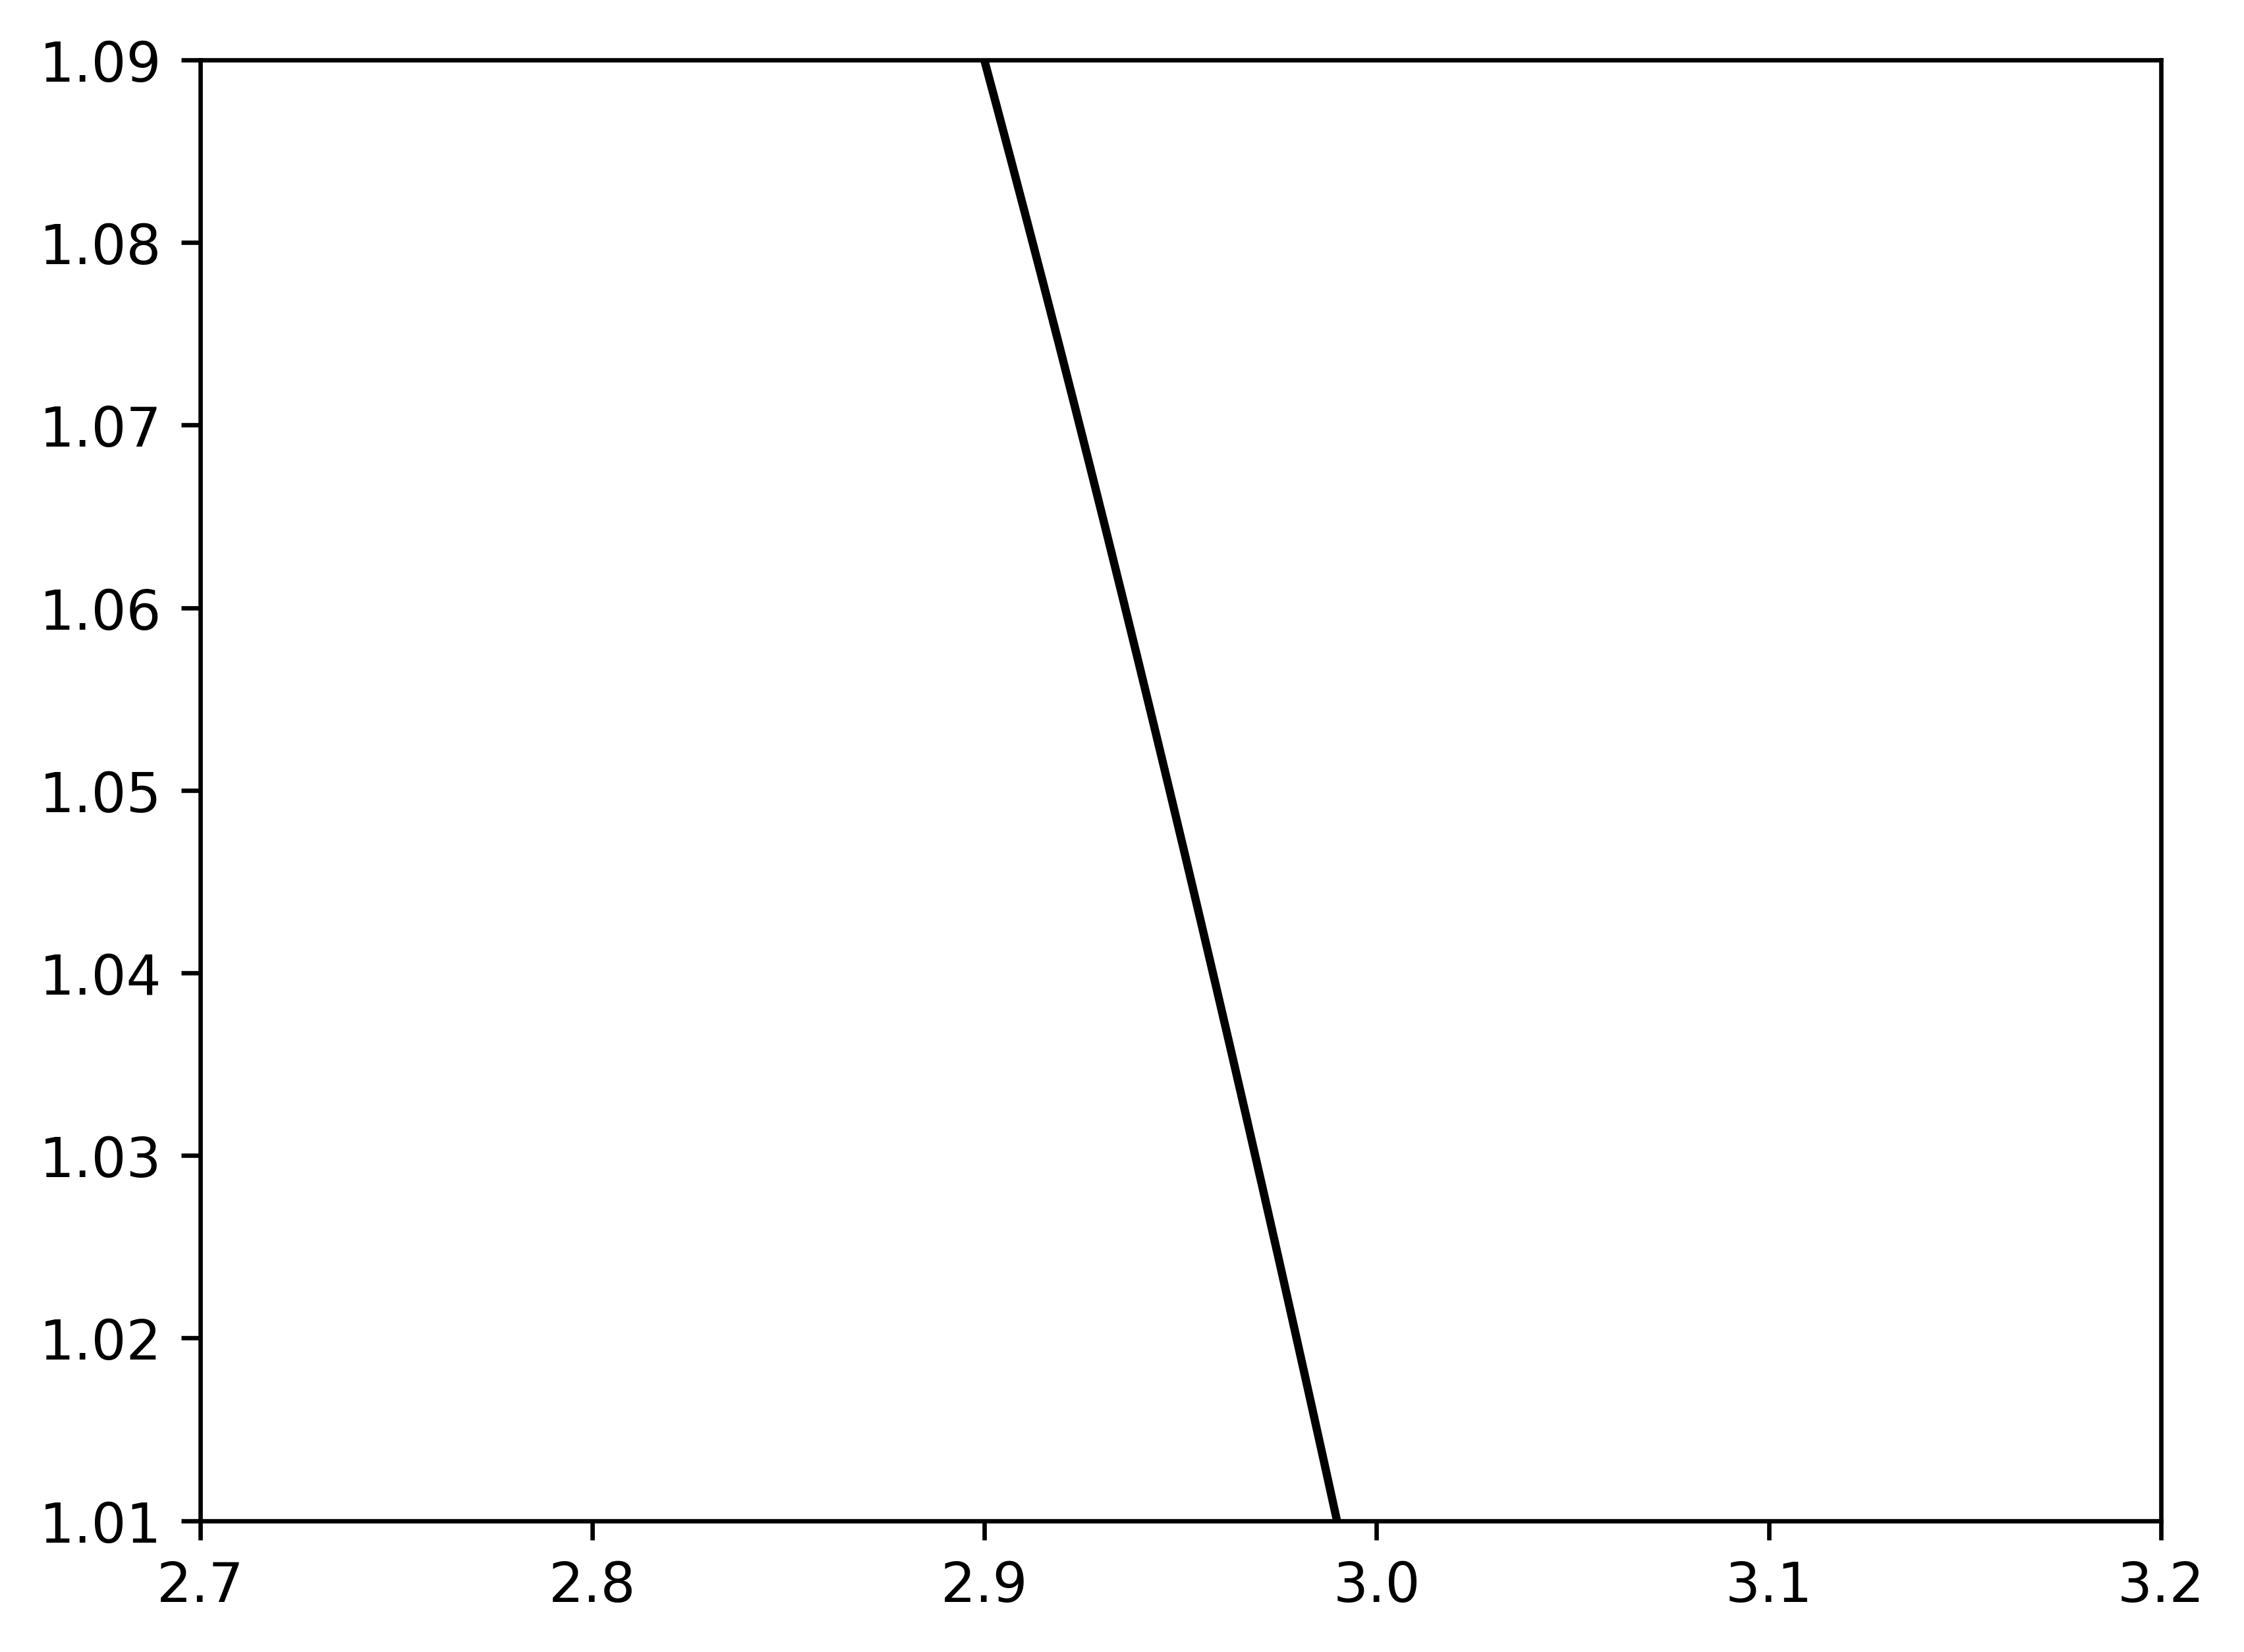

In [20]:
plt.figure(dpi=600)
plt.plot(J, E_plot_A2_Plus, 'k')
plt.plot(J, E_plot_A2_Minus, 'k')
plt.hlines(1, 2.6, 5.0, 'k')
plt.ylim(1.01, 1.09)
plt.xlim(2.7, 3.2)